<a href="https://colab.research.google.com/github/GJ-007-sage/Generative-Models-/blob/main/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import time

In [12]:
# Load CIFAR-10 dataset
(train_images, _), (_, _) = tf.keras.datasets.cifar10.load_data()

# Normalize images to the range [-1, 1]
train_images = train_images.astype('float32')
train_images = (train_images - 127.5) / 127.5

# Reshape to add channel dimension (batch_size, 32, 32, 3)
train_images = train_images.reshape(train_images.shape[0], 32, 32, 3)

# Batch the data using tf.data.Dataset
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [13]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)

    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    assert model.output_shape == (None, 32, 32, 3)
    return model


In [14]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model


In [15]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizers
generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [16]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [17]:
EPOCHS = 50
losses_gen = []
losses_disc = []

for epoch in range(EPOCHS):
    start = time.time()
    for image_batch in train_dataset:
        gen_loss, disc_loss = train_step(image_batch)

    losses_gen.append(gen_loss.numpy())
    losses_disc.append(disc_loss.numpy())

    if epoch % 5 == 0:
        print(f"Epoch {epoch + 1}, Generator Loss: {gen_loss.numpy()}, Discriminator Loss: {disc_loss.numpy()}")

    # Save generated images every 5 epochs
    if epoch % 5 == 0:
        noise = tf.random.normal([16, 100])
        generated_images = generator(noise, training=False)
        plt.figure(figsize=(4, 4))
        for i in range(generated_images.shape[0]):
            plt.subplot(4, 4, i + 1)
            plt.imshow((generated_images[i] + 1) / 2)  # Rescale to [0, 1]
            plt.axis('off')
        plt.savefig(f"generated_images_epoch_{epoch + 1}.png")
        plt.close()

    print(f"Time for epoch {epoch + 1}: {time.time()-start} sec")

Epoch 1, Generator Loss: 2.143597364425659, Discriminator Loss: 0.3148890435695648
Time for epoch 1: 22.189589977264404 sec
Time for epoch 2: 10.90837049484253 sec
Time for epoch 3: 11.02729320526123 sec
Time for epoch 4: 11.112279176712036 sec
Time for epoch 5: 11.193936109542847 sec
Epoch 6, Generator Loss: 1.465321660041809, Discriminator Loss: 0.8695034980773926
Time for epoch 6: 12.128506422042847 sec
Time for epoch 7: 11.370887041091919 sec
Time for epoch 8: 11.438990592956543 sec
Time for epoch 9: 11.502957582473755 sec
Time for epoch 10: 11.481487035751343 sec
Epoch 11, Generator Loss: 1.8531453609466553, Discriminator Loss: 0.9315336346626282
Time for epoch 11: 11.8170804977417 sec
Time for epoch 12: 11.554900407791138 sec
Time for epoch 13: 11.607030868530273 sec
Time for epoch 14: 11.653392791748047 sec
Time for epoch 15: 11.68537974357605 sec
Epoch 16, Generator Loss: 2.361194372177124, Discriminator Loss: 0.6349042057991028
Time for epoch 16: 12.017935514450073 sec
Time fo

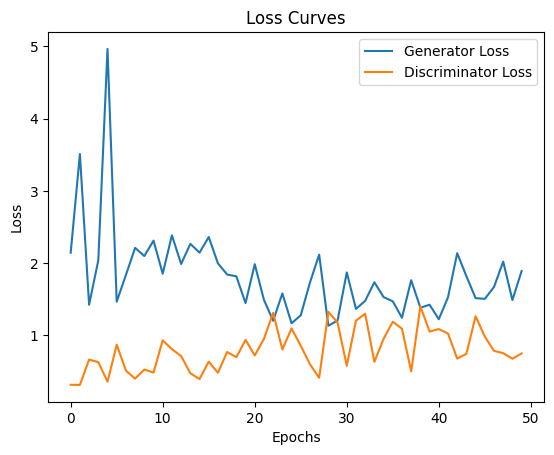

In [18]:
# Plot the loss curves
plt.plot(losses_gen, label='Generator Loss')
plt.plot(losses_disc, label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

In [19]:
# Document minimum error observed
min_gen_loss = np.min(losses_gen)
min_disc_loss = np.min(losses_disc)
print(f"Minimum Generator Loss: {min_gen_loss}")
print(f"Minimum Discriminator Loss: {min_disc_loss}")

Minimum Generator Loss: 1.1323322057724
Minimum Discriminator Loss: 0.3129439353942871


In [20]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(8*8*512, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Reshape((8, 8, 512)))
    assert model.output_shape == (None, 8, 8, 512)

    model.add(tf.keras.layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    assert model.output_shape == (None, 32, 32, 3)
    return model


In [21]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model


Epoch 1, Generator Loss: 1.714990258216858, Discriminator Loss: 1.235014796257019
Time for epoch 1: 11.316930532455444 sec
Time for epoch 2: 11.00729489326477 sec
Time for epoch 3: 11.10113263130188 sec
Time for epoch 4: 11.172880172729492 sec
Time for epoch 5: 11.244999170303345 sec
Epoch 6, Generator Loss: 1.564476490020752, Discriminator Loss: 0.8465019464492798
Time for epoch 6: 11.738783597946167 sec
Time for epoch 7: 11.397473812103271 sec
Time for epoch 8: 11.460651874542236 sec
Time for epoch 9: 11.518905401229858 sec
Time for epoch 10: 11.519926071166992 sec
Epoch 11, Generator Loss: 2.0737464427948, Discriminator Loss: 0.5670562982559204
Time for epoch 11: 11.847624778747559 sec
Time for epoch 12: 11.631410598754883 sec
Time for epoch 13: 11.659696578979492 sec
Time for epoch 14: 11.71182370185852 sec
Time for epoch 15: 11.755223512649536 sec
Epoch 16, Generator Loss: 2.1572530269622803, Discriminator Loss: 0.6925952434539795
Time for epoch 16: 12.033743619918823 sec
Time for

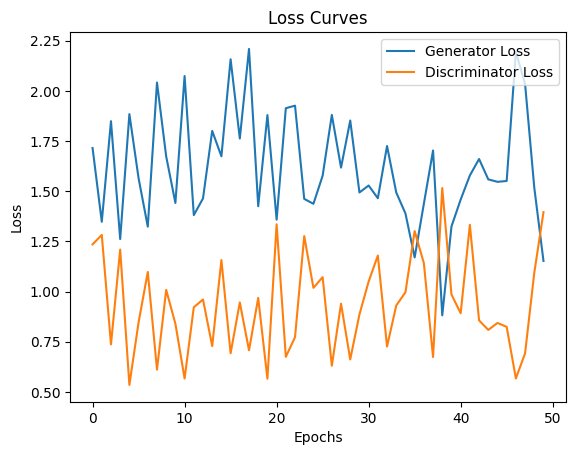

Minimum Generator Loss: 0.8814386129379272
Minimum Discriminator Loss: 0.5348133444786072


In [22]:
EPOCHS = 50
losses_gen = []
losses_disc = []

for epoch in range(EPOCHS):
    start = time.time()
    for image_batch in train_dataset:
        gen_loss, disc_loss = train_step(image_batch)

    losses_gen.append(gen_loss.numpy())
    losses_disc.append(disc_loss.numpy())

    if epoch % 5 == 0:
        print(f"Epoch {epoch + 1}, Generator Loss: {gen_loss.numpy()}, Discriminator Loss: {disc_loss.numpy()}")

    # Save generated images every 5 epochs
    if epoch % 5 == 0:
        noise = tf.random.normal([16, 100])
        generated_images = generator(noise, training=False)
        plt.figure(figsize=(4, 4))
        for i in range(generated_images.shape[0]):
            plt.subplot(4, 4, i + 1)
            plt.imshow((generated_images[i] + 1) / 2)  # Rescale to [0, 1]
            plt.axis('off')
        plt.savefig(f"generated_images_epoch_{epoch + 1}.png")
        plt.close()

    print(f"Time for epoch {epoch + 1}: {time.time()-start} sec")

# Plot the loss curves
plt.plot(losses_gen, label='Generator Loss')
plt.plot(losses_disc, label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

# Document minimum error observed
min_gen_loss = np.min(losses_gen)
min_disc_loss = np.min(losses_disc)
print(f"Minimum Generator Loss: {min_gen_loss}")
print(f"Minimum Discriminator Loss: {min_disc_loss}")
